In [1]:
import sys,os,os.path
sys.path.append("../../") # if you move files around, you need to adjust this!
sys.path.append(os.path.expanduser('~/code/eol_hsrl_python'))
os.environ['ICTDIR']='/home/e78368jw/Documents/NEXT_CODE/IC'

#%load_ext autoreload
#%autoreload 2
#%matplotlib notebook
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['mathtext.fontset'] = 'stix'
rcParams['font.family'] = 'STIXGeneral'
rcParams['figure.figsize'] = [10, 8]
rcParams['font.size'] = 22

import pandas as pd
import numpy  as np
import tables as tb

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as clrs

import IC.invisible_cities.core.core_functions                   as     coref
import IC.invisible_cities.io.dst_io                           as     dstio

from IC.invisible_cities.cities                 import beersheba as beerfun

from IC.invisible_cities.evm.event_model                          import HitCollection

from IC.invisible_cities.database.load_db       import DataSiPM

from IC.invisible_cities.evm.event_model        import Cluster, Hit
from IC.invisible_cities.types.ic_types         import xy
from IC.invisible_cities.reco.paolina_functions import voxelize_hits

from IC.invisible_cities.evm.event_model        import HitEnergy
from IC.invisible_cities.cities.beersheba          import DeconvolutionMode
from IC.invisible_cities.cities.beersheba          import CutType

from IC.invisible_cities.reco import hits_functions as hif

from IC.invisible_cities.reco.deconv_functions import deconvolve
from IC.invisible_cities.reco.deconv_functions import deconvolution_input
from IC.invisible_cities.reco.deconv_functions import InterpolationMethod

import IC.invisible_cities.io.mcinfo_io as mcio

from collections import defaultdict

import matplotlib.cm as cm
from matplotlib.colors import Normalize

pd.set_option('display.max_rows', 200)

import imageio

#import functions as func


In [2]:
file_path = '../toolbox/example_files/4bar_p1a_soph.h5'

In [3]:
# read in
df = pd.read_hdf(file_path, 'RECO/Events', start = 0, stop = 1000000)
events = np.unique(df.event.to_numpy())

In [11]:
# read in
dst = pd.read_hdf(file_path, 'DST/Events', start = 0, stop = 1000000)
display(dst[dst.event == 20128])

,event,time,s1_peak,s2_peak,nS1,nS2,S1w,S1h,S1e,S1t,...,Nsipm,DT,Z,Zrms,X,Y,R,Phi,Xrms,Yrms
47,20128,2.012842e+10,0,0,1,1,575.0,267.0,1125.0,10000.0,...,14,670.499878,583.3349,5.365779,298.979685,345.355872,456.792656,0.857249,13.761869,14.203146


In [4]:
display(df)
print(df.columns)

,event,time,npeak,Xpeak,Ypeak,nsipm,X,Y,Xrms,Yrms,Z,Q,E,Qc,Ec,track_id,Ep
0,20002,2.000381e+10,0,422.463777,191.296821,1,412.275,260.975,0.0,0.0,279.730957,6.202899,364.111642,-1.0,0.000854,-1,-1.0
1,20002,2.000381e+10,0,422.463777,191.296821,1,427.825,260.975,0.0,0.0,279.730957,5.739130,336.888358,-1.0,0.000790,-1,-1.0
2,20002,2.000381e+10,0,422.463777,191.296821,1,412.275,260.975,0.0,0.0,280.626160,5.275362,240.800018,-1.0,0.000565,-1,-1.0
3,20002,2.000381e+10,0,422.463777,191.296821,1,427.825,260.975,0.0,0.0,280.626160,6.028986,275.200012,-1.0,0.000645,-1,-1.0
4,20002,2.000381e+10,0,422.463777,191.296821,1,412.275,245.425,0.0,0.0,281.471588,9.159420,304.393341,-1.0,0.001198,-1,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,20360008,2.036001e+13,1,344.431674,187.932922,1,366.625,198.775,0.0,0.0,600.723267,9.275362,663.478271,-1.0,0.001545,-1,-1.0
999996,20360008,2.036001e+13,1,344.431674,187.932922,1,366.625,198.775,0.0,0.0,601.589111,5.101449,1488.000000,-1.0,0.003465,-1,-1.0
999997,20360008,2.036001e+13,1,344.431674,187.932922,1,366.625,198.775,0.0,0.0,602.466064,5.275362,490.520416,-1.0,0.001142,-1,-1.0
999998,20360008,2.036001e+13,1,344.431674,187.932922,1,381.175,168.675,0.0,0.0,602.466064,5.275362,490.520416,-1.0,0.001130,-1,-1.0


Index(['event', 'time', 'npeak', 'Xpeak', 'Ypeak', 'nsipm', 'X', 'Y', 'Xrms',
       'Yrms', 'Z', 'Q', 'E', 'Qc', 'Ec', 'track_id', 'Ep'],
      dtype='object')


In [5]:
df_total_E = []
event_IDs = []
for event, one_df in df.groupby("event"):
    df_total_E.append(one_df.Ec.sum())
    event_IDs.append(event)

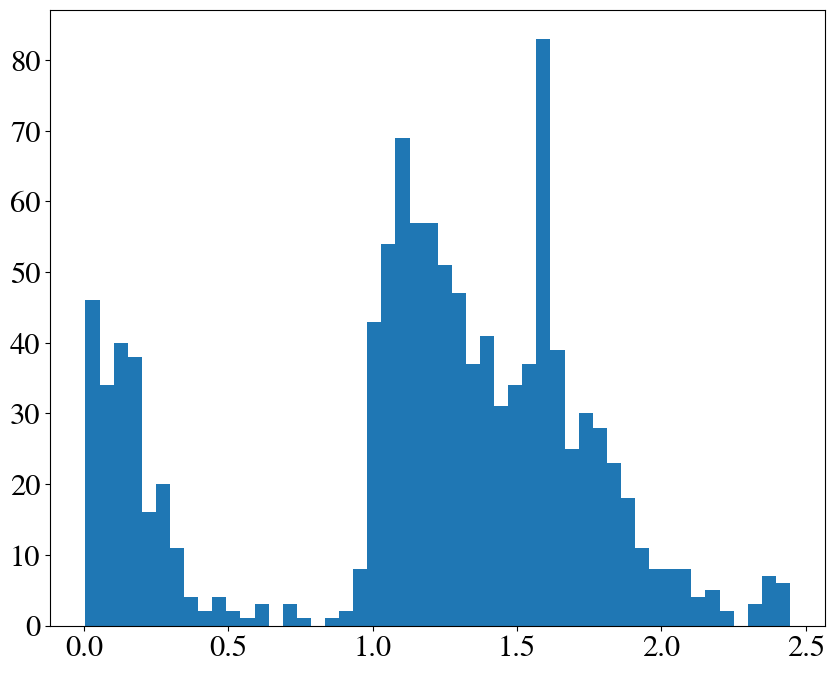

In [6]:
plt.hist(df_total_E, bins = 50)
plt.show()

In [7]:
low_E_events = [a for a, b in zip(event_IDs, df_total_E) if b < 0.5]
print(low_E_events)

[20006, 20008, 20016, 20026, 20088, 20128, 20144, 40014, 40062, 40152, 40162, 40166, 40170, 40176, 40182, 220064, 220076, 220102, 220126, 220152, 220158, 220160, 220166, 220170, 2020006, 2020022, 2020024, 2020026, 2020046, 2020054, 2020066, 2020078, 2020112, 2020114, 2020116, 2020118, 2020132, 2020136, 2020140, 2020172, 2020178, 2020190, 2040008, 2040024, 2040028, 2040056, 2040058, 2040062, 2040072, 2040082, 2040154, 2040162, 2040164, 2040168, 2040174, 20040000, 20040036, 20040054, 20040070, 20040074, 20040076, 20040090, 20040096, 20040134, 20040144, 20040146, 20040152, 20040154, 20060006, 20060016, 20060056, 20060062, 20060090, 20080018, 20080044, 20080066, 20080072, 20080080, 20080094, 20080100, 20080104, 20080126, 20080130, 20080132, 20100010, 20100022, 20100080, 20100096, 20100114, 20120004, 20120008, 20120022, 20120026, 20120038, 20120042, 20120056, 20120086, 20120108, 20120118, 20120122, 20120142, 20120148, 20140002, 20140036, 20140052, 20140070, 20140106, 20140110, 20140124, 201

In [17]:
evt_interest = np.sum(df[df.event == 20128].Q>7.5)
display(evt_interest)

16

In [34]:
def plot_evt(evt, i):
    q_cut = 4
    drop_dist       = [16, 16]
    cut_sensors       = beerfun.cut_over_Q   (q_cut, ['E', 'Ec'])
    drop_sensors      = beerfun.drop_isolated(drop_dist, ['E', 'Ec'])
    hits_cut = coref.timefunc(cut_sensors)(evt.copy())
    hits_drop = coref.timefunc(drop_sensors)(hits_cut.copy())
    pitch = 15.55
    # then applying transformations to convert to 'SiPM outputs'
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))


    xx = np.arange(hits_drop.X.min(), hits_drop.X.max() + pitch, pitch)
    yy = np.arange(hits_drop.Y.min(), hits_drop.Y.max() + pitch, pitch)
    zz = hits_cut.Z.unique()

    axes[0].hist2d(hits_drop.X, hits_drop.Y, bins=[xx, yy], weights=hits_drop.Q, cmin=0.0001);
    axes[0].set_xlabel('X (mm)');
    axes[0].set_ylabel('Y (mm)');

    axes[1].hist2d(hits_drop.X, hits_drop.Z, bins=[xx, zz], weights=hits_drop.Q, cmin=0.0001);
    axes[1].set_xlabel('X (mm)');
    axes[1].set_ylabel('Z (mm)');


    axes[2].hist2d(hits_drop.Y, hits_drop.Z, bins=[yy, zz], weights=hits_drop.Q, cmin=0.0001);
    axes[2].set_xlabel('Y (mm)');
    axes[2].set_ylabel('Z (mm)');

    fig.suptitle('Processed Sensors Signal_' + str(i), fontsize=30)

    #plt.tight_layout()
    fig.show()

Time spent in cut_over_Q: 0.028231143951416016 s
Time spent in drop_isolated: 0.02150416374206543 s


/tmp/ipykernel_43475/1003121392.py:33: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


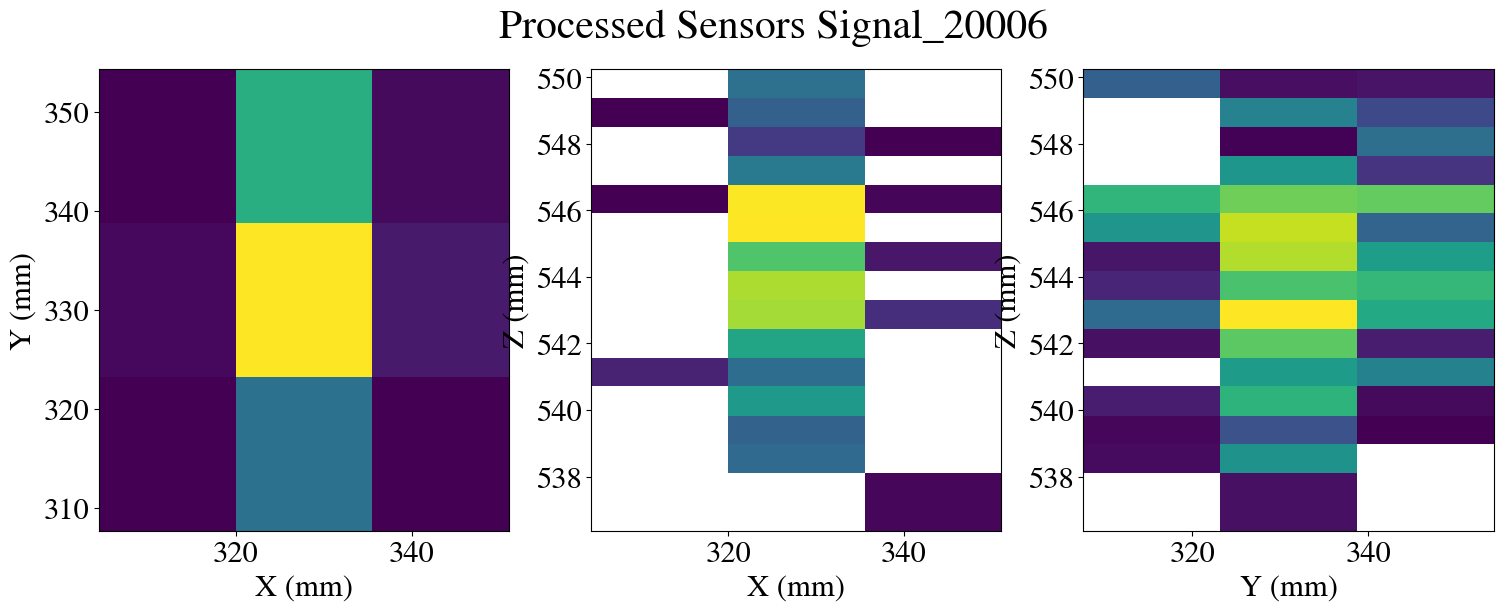

In [25]:
plot_evt(evt_interest)

20006
Time spent in cut_over_Q: 0.0248410701751709 s
Time spent in drop_isolated: 0.019549131393432617 s
20016
Time spent in cut_over_Q: 0.027175426483154297 s
Time spent in drop_isolated: 0.015619516372680664 s


/tmp/ipykernel_43475/3089118166.py:33: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


20088
Time spent in cut_over_Q: 0.019520044326782227 s
Time spent in drop_isolated: 0.008939981460571289 s


/tmp/ipykernel_43475/3089118166.py:17: UserWarning: Attempting to set identical bottom == top == -109.725 results in singular transformations; automatically expanding.
  axes[0].hist2d(hits_drop.X, hits_drop.Y, bins=[xx, yy], weights=hits_drop.Q, cmin=0.0001);
/tmp/ipykernel_43475/3089118166.py:26: UserWarning: Attempting to set identical left == right == -109.725 results in singular transformations; automatically expanding.
  axes[2].hist2d(hits_drop.Y, hits_drop.Z, bins=[yy, zz], weights=hits_drop.Q, cmin=0.0001);


20128
Time spent in cut_over_Q: 0.013727188110351562 s
Time spent in drop_isolated: 0.00908517837524414 s
20144
Time spent in cut_over_Q: 0.010867834091186523 s
Time spent in drop_isolated: 0.015204906463623047 s
40014
Time spent in cut_over_Q: 0.006593465805053711 s
Time spent in drop_isolated: 0.00806736946105957 s
40062
Time spent in cut_over_Q: 0.017934322357177734 s
Time spent in drop_isolated: 0.012244939804077148 s
40152
Time spent in cut_over_Q: 0.006556272506713867 s
Time spent in drop_isolated: 0.006130218505859375 s
40162
Time spent in cut_over_Q: 0.008275032043457031 s
Time spent in drop_isolated: 0.010637283325195312 s
40166
Time spent in cut_over_Q: 0.006463289260864258 s
Time spent in drop_isolated: 0.0060541629791259766 s
40170
Time spent in cut_over_Q: 0.012880802154541016 s
Time spent in drop_isolated: 0.0028228759765625 s


ValueError: arange: cannot compute length

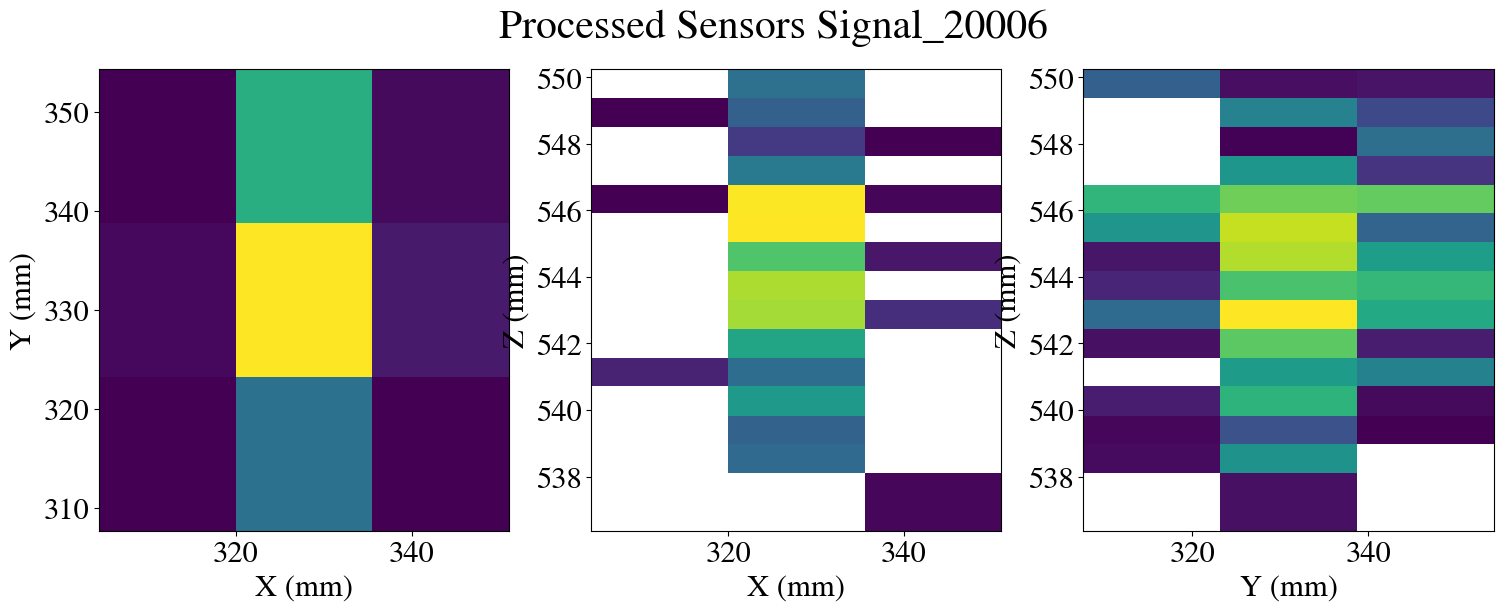

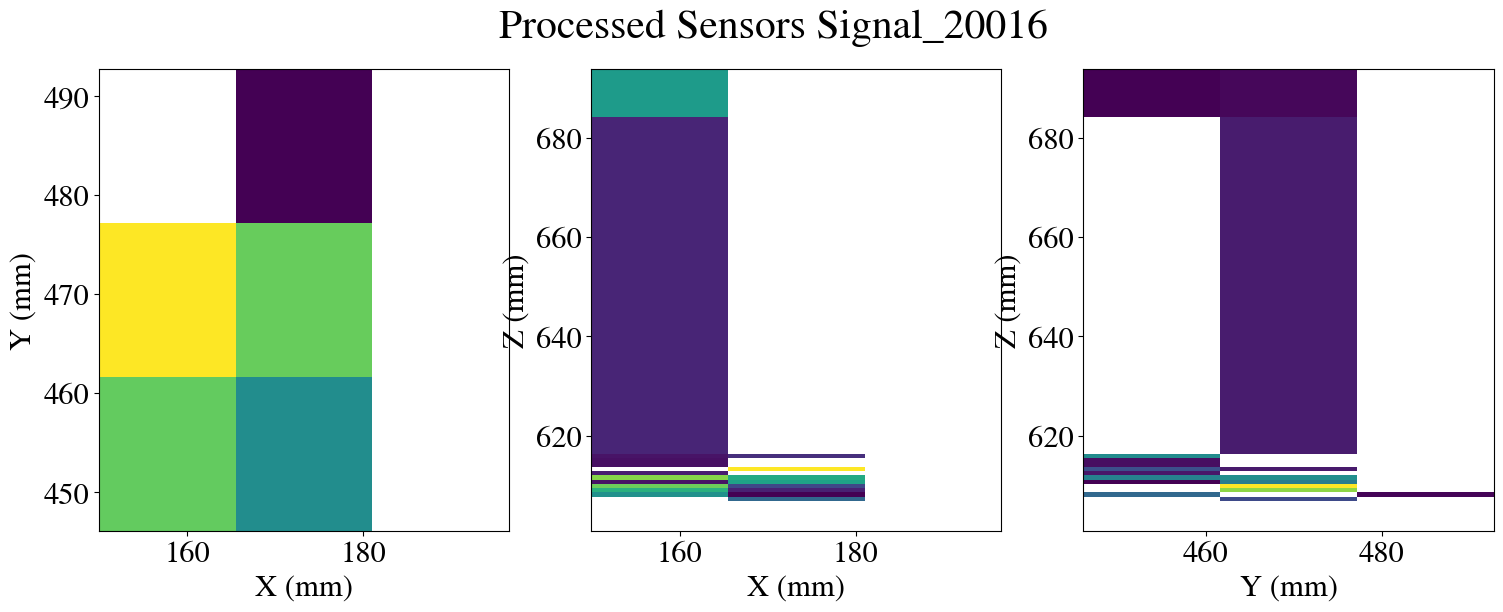

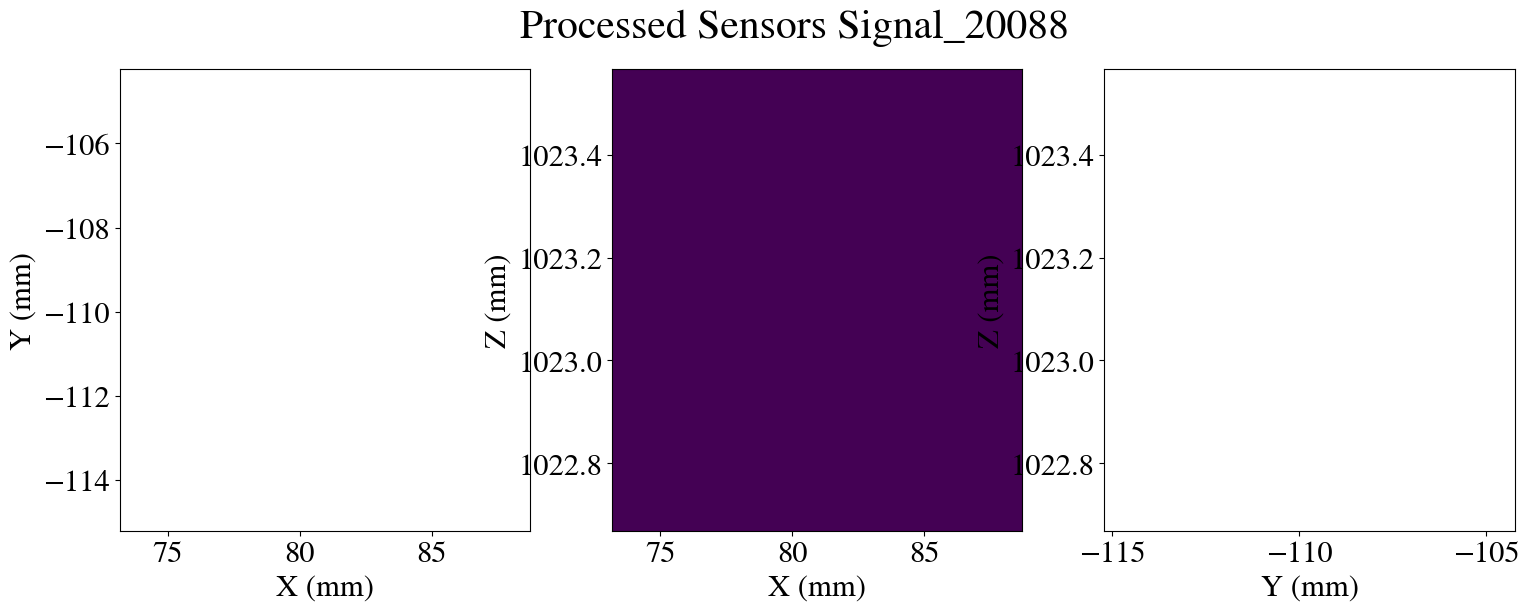

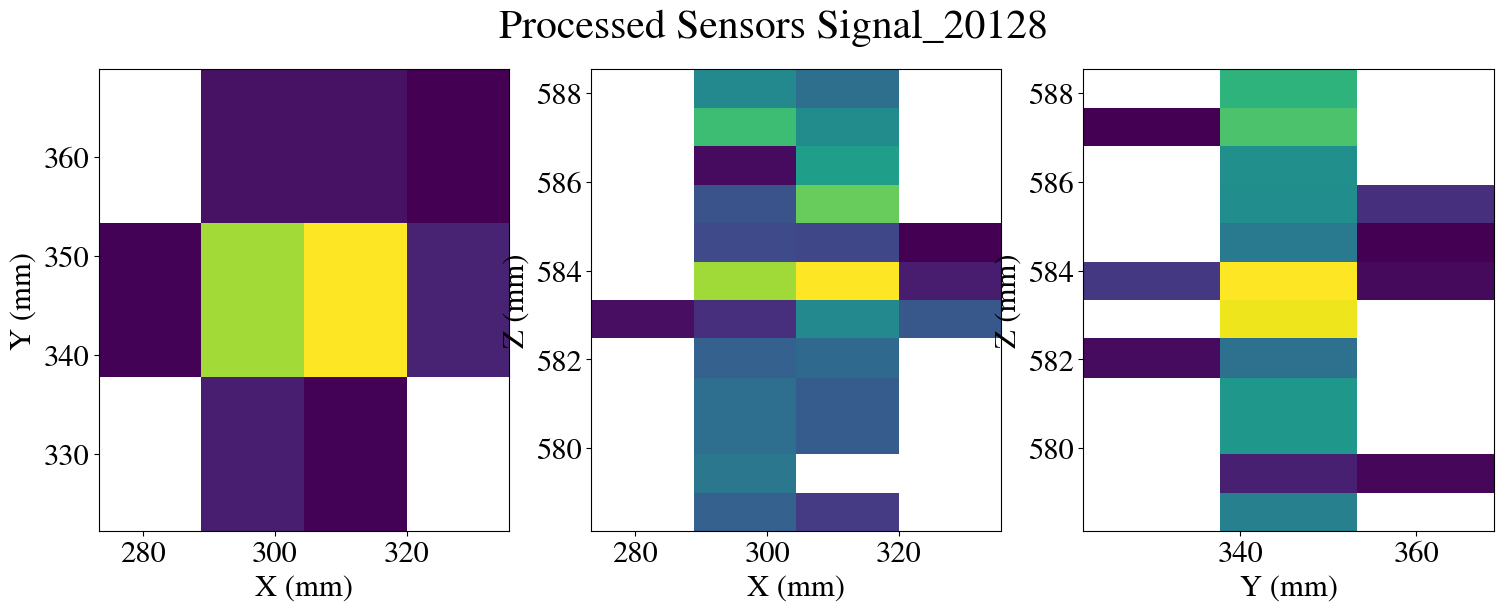

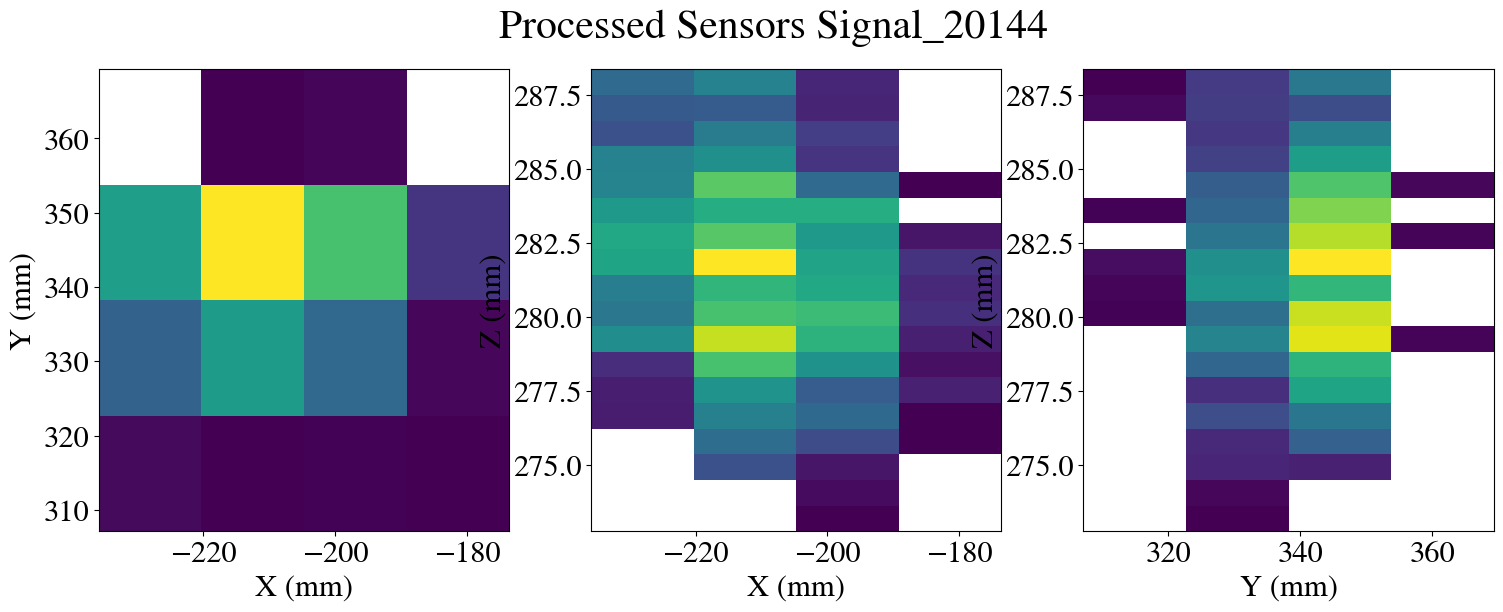

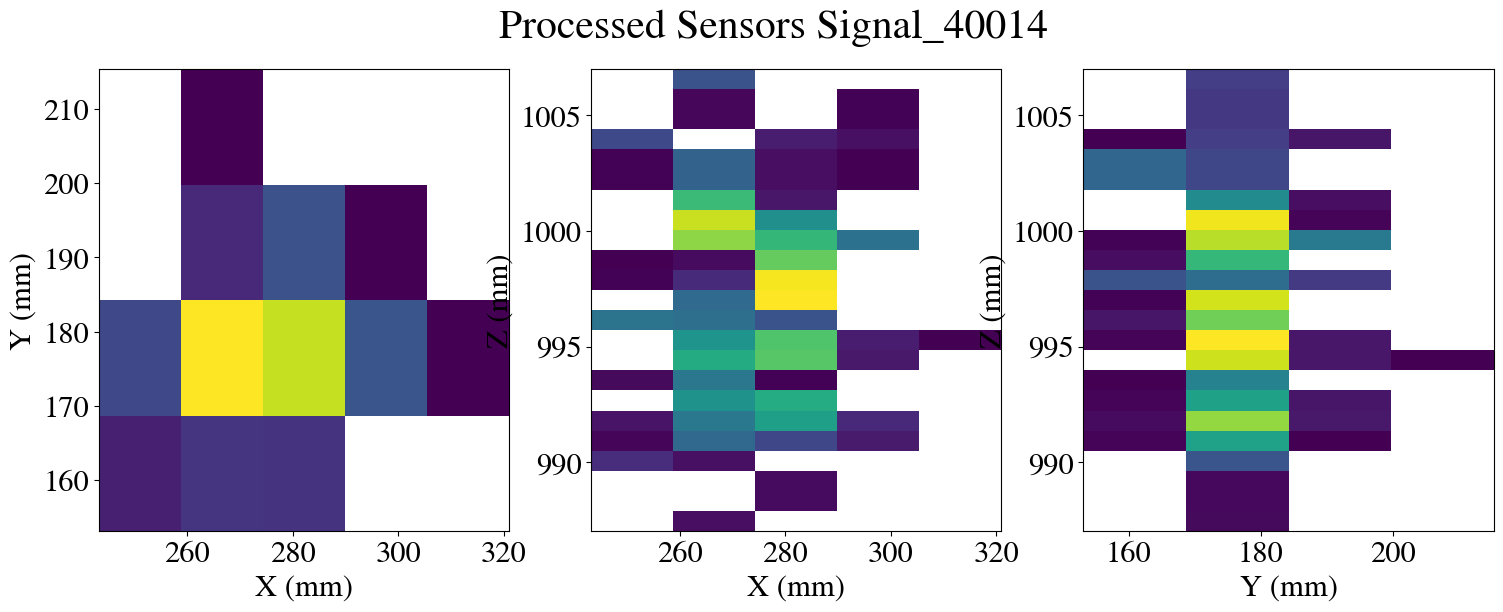

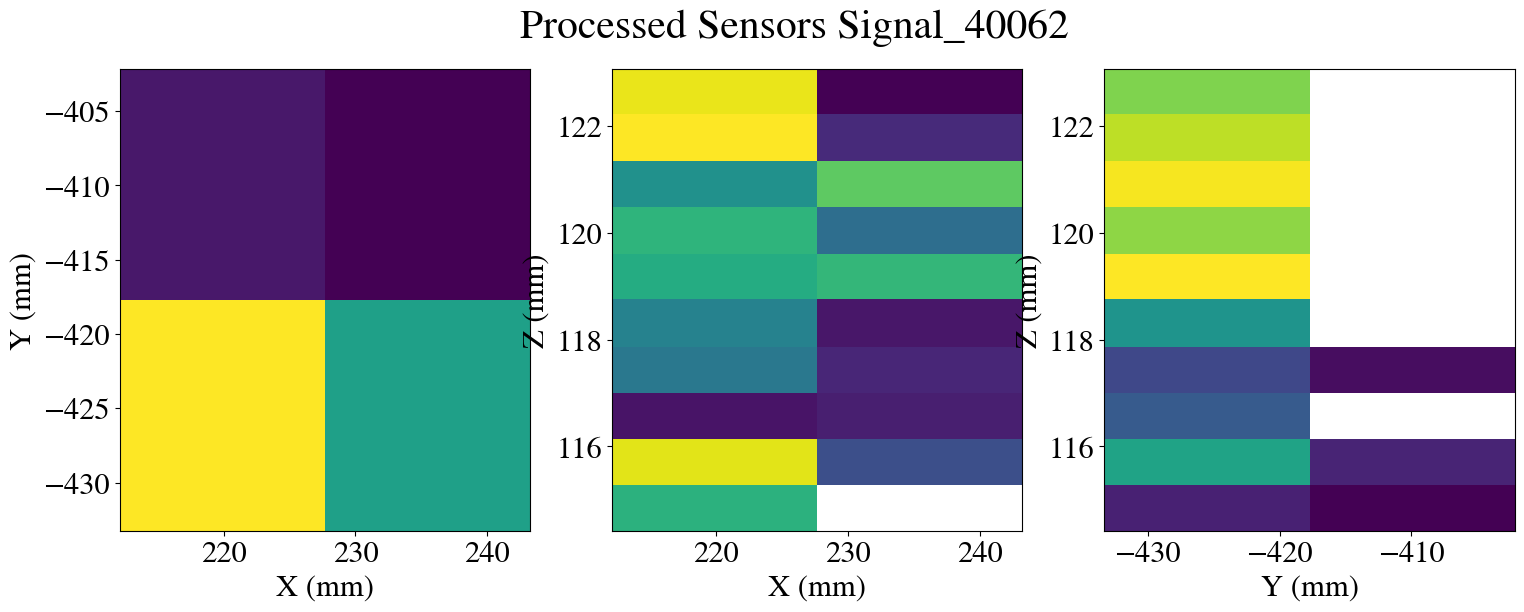

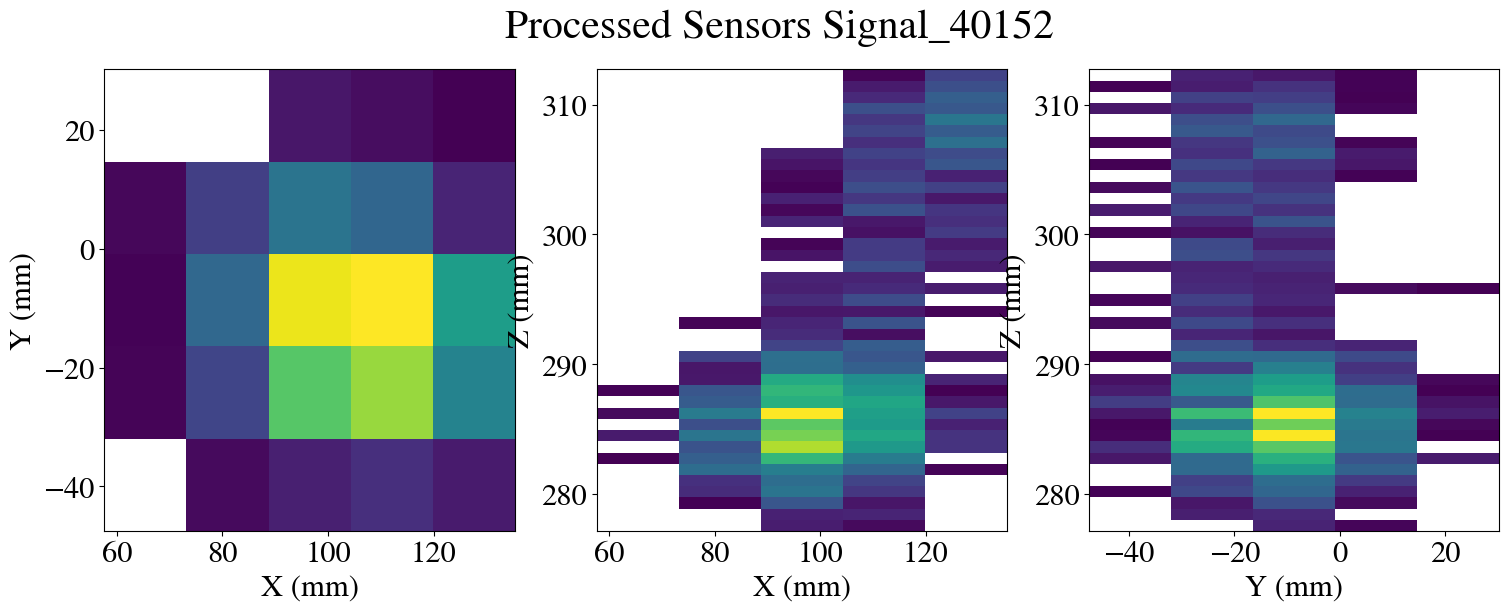

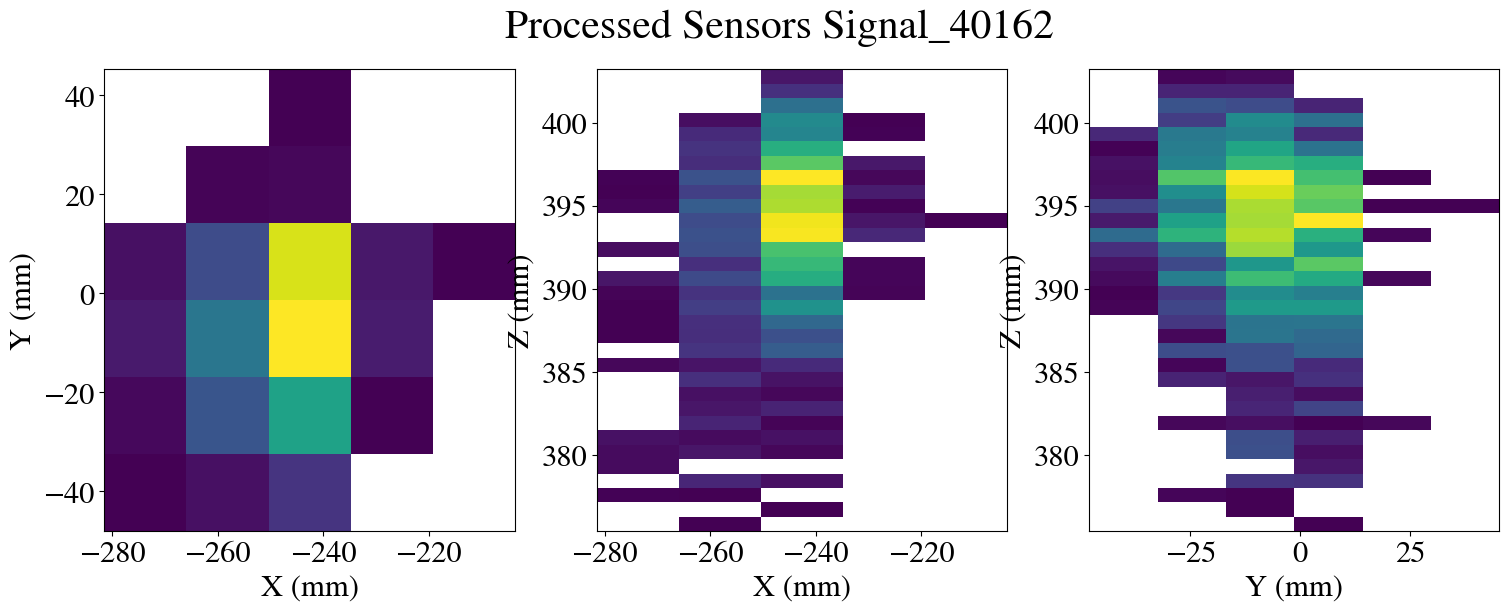

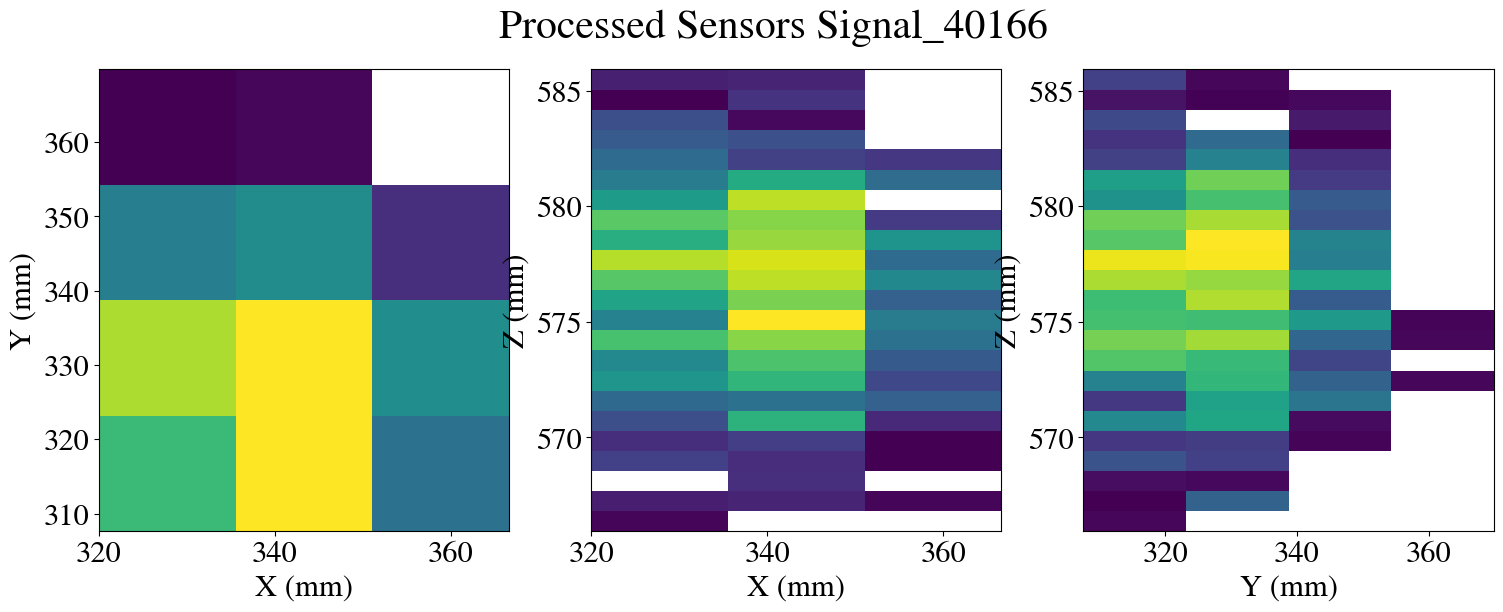

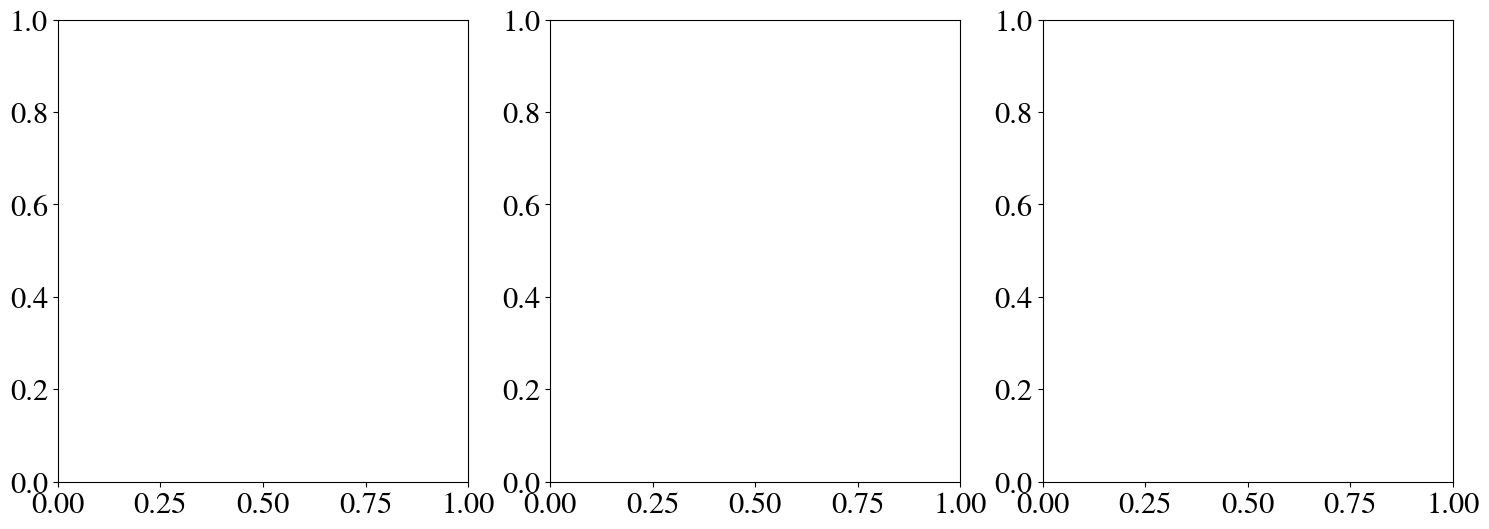

In [37]:
q = [20006, 20016, 20088, 20128, 20144, 40014, 40062, 40152, 40162, 40166, 40170, 40176, 40182, 220064, 220076, 220102, 220126, 220152, 220158, 220160, 220166, 220170, 2020006, 2020022, 2020024, 2020026, 2020046, 2020054, 2020066, 2020078, 2020112, 2020114, 2020116, 20140106, 20140110, 20140124, 20140128, 20140134, 20140152, 20140168, 20140184, 20140190, 20140202, 20160028, 20160050, 20160074, 20160080, 20160150, 20180058, 20180096, 20180120, 20180128, 20180132, 20180166, 20180170, 20200010, 20200016, 20200022, 20200026, 20200040, 20200044, 20200062, 20200072, 20200088, 20200100, 20200102, 20200118, 20200140, 20220004, 20220012, 20220020, 20220026, 20220030, 20220044, 20220086, 20220090, 20220136, 20220150, 20220166, 20220170, 20220172, 20220190, 20220200, 20240016, 20240022, 20240026, 20240030, 20240038, 20240040, 20240048, 20240094, 20240108, 20240132, 20260174, 20280016, 20280024, 20280030, 20280032, 20280068, 20280102, 20300002, 20300032, 20320158, 20320168, 20340016, 20340020, 20340032, 20340042, 20340056, 20340072, 20340076, 20340078, 20340106, 20340120, 20340128]

for i in q:
    x = df[df.event == i]
    print(i)
    plot_evt(x, i)